# Проект: Обучение с учителем: качество модели

__Описание проекта:__   
Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться.     
Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.   
«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования.

__Цель работы__: разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

__План работы__:    
1) Проанализировать имеющиеся данные:  
* какова покупательская активность    
* какой тип продукции продается больше всего    
* сколько времени покупатель проводит на сайте    
* как часто покупатель посещает сайт    
* какова прибыль компании 

2) Провести предобработку данных:
* удалить дубликаты  
* заполнить или удалить пропуски  
* проверить типы данных  

3) Провести исследовательский анализ: отобрать клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период.   
4) Провести корреляционный анализ;  
5) Создать модели МО и применить их;  
6) Сделать вывод.  

In [1]:
!pip install phik 

In [2]:
!pip install shap

In [3]:
!pip install -U scikit-learn 

In [4]:
# Загрузим необходимые библиотеки
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import(
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler, 
    MinMaxScaler,
    LabelEncoder
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score
)
from sklearn.model_selection import (
    RandomizedSearchCV, 
    train_test_split, 
    GridSearchCV
)

from phik.report import plot_correlation_matrix
from phik import report
from statsmodels.stats.outliers_influence import variance_inflation_factor 

import shap
import warnings
warnings.filterwarnings("ignore")

## Загрузка данных

In [5]:
# Загружаем данные
try:
    market_file = pd.read_csv('/datasets/market_file.csv')
    market_money = pd.read_csv('/datasets/market_money.csv')
    market_time = pd.read_csv('/datasets/market_time.csv')
    money_data = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')
except:
    market_file = pd.read_csv('market_file.csv')
    market_money = pd.read_csv('market_money.csv')
    market_time = pd.read_csv('market_time.csv')
    money_data = pd.read_csv('money.csv', sep=';', decimal=',')

In [6]:
market_file.head() #Выводим первые 5 строк таблицы

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


__Описание:__   
Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.  
* _id_ — номер покупателя в корпоративной базе данных.
* _Покупательская активность_ — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
* _Тип сервиса_ — уровень сервиса, например «премиум» и «стандарт».
* _Разрешить сообщать_ — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
* _Маркет_актив_6_мес_ — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
* _Маркет_актив_тек_мес_ — количество маркетинговых коммуникаций в текущем месяце.
* _Длительность_ — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
* _Акционные_покупки_ — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
* _Популярная_категория_ — самая популярная категория товаров у покупателя за последние 6 месяцев.
* _Средний_просмотр_категорий_за_визит_ — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
* _Неоплаченные_продукты_штук_квартал_ — общее число неоплаченных товаров в корзине за последние 3 месяца.
* _Ошибка_сервиса_ — число сбоев, которые коснулись покупателя во время посещения сайта.
* _Страниц_за_визит_ — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

In [7]:
market_file.shape # Выводим размерность таблицы (строки, колонки)

(1300, 13)

In [8]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


__Описание:__   
Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
* _id_ — номер покупателя в корпоративной базе данных.  
* _Период_ — название периода, во время которого зафиксирована выручка.  Например, 'текущий_месяц' или 'предыдущий_месяц'.  
* _Выручка_ — сумма выручки за период.  

In [9]:
market_money.shape

(3900, 3)

In [10]:
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [11]:
market_time = market_time.rename(columns={'минут': 'Минуты'})
market_time.head()

,id,Период,Минуты
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


__Описание:__   
Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.   
* _id_ — номер покупателя в корпоративной базе данных.
* _Период_ — название периода, во время которого зафиксировано общее время.
* _Минуты_ — значение времени, проведённого на сайте, в минутах.

In [12]:
market_time.shape

(2600, 3)

In [13]:
money_data.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


__Описание:__    
Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
* _id_ — номер покупателя в корпоративной базе данных.  
* _Прибыль_ — значение прибыли.  

__Вывод по загрузке данных:__  
1) Загрузили данные;    
2) Проанализировали каждый датасет: данные соответствуют описанию;  
3) Переименовали столбец в датасете market_time: 'минут' -> 'Минуты'.  

## Предобработка данных

In [14]:
# Выводим общую информацию по данным
datasets = [market_file, market_money, market_time, money_data]

for dataset in datasets:
    dataset.info()
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

Видим, что в данных нет пропусков. Типы данных соответствуют самим данным.

Поработаем с дубликатами:

In [15]:
for dupl in datasets:
    print(f'Количество дубликатов в таблице : {dupl.duplicated().sum()}')

Количество дубликатов в таблице : 0
Количество дубликатов в таблице : 0
Количество дубликатов в таблице : 0
Количество дубликатов в таблице : 0


Дубликатов нет

Поработаем с уникальными значениями:

Датасет __market_file__

In [16]:
for column in market_file.select_dtypes(include='object').columns.to_list():
    print(market_file[column].value_counts(), '\n')

Прежний уровень    802
Снизилась          498
Name: Покупательская активность, dtype: int64 

стандарт     914
премиум      376
стандартт     10
Name: Тип сервиса, dtype: int64 

да     962
нет    338
Name: Разрешить сообщать, dtype: int64 

Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: Популярная_категория, dtype: int64 



В столбце __Тип сервиса__ видим два значения __стандарт__ и __стандартт.__   
Заменим: стандартт -> стандарт

In [17]:
market_file['Тип сервиса'] = market_file['Тип сервиса'].replace('стандартт', 'стандарт')

In [18]:
market_file['Тип сервиса'].value_counts() # Замена произвелась

стандарт    924
премиум     376
Name: Тип сервиса, dtype: int64

Датасет __market_money__

In [19]:
for column in market_money.select_dtypes(include='object').columns.to_list():
    print(market_money[column].value_counts(), '\n')

предыдущий_месяц       1300
текущий_месяц          1300
препредыдущий_месяц    1300
Name: Период, dtype: int64 



Ничего менять не будем.

Датасет __market_time__

In [20]:
for column in market_time.select_dtypes(include='object').columns.to_list():
    print(market_time[column].value_counts(), '\n')

предыдцщий_месяц    1300
текущий_месяц       1300
Name: Период, dtype: int64 



Заменим: предыдцщий_месяц -> предыдущий_месяц

In [21]:
market_time['Период'] = market_time['Период'].replace('предыдцщий_месяц', 'предыдущий_месяц')

In [22]:
market_time['Период'].value_counts() # Замена произвелась

предыдущий_месяц    1300
текущий_месяц       1300
Name: Период, dtype: int64

Датасет __money_data__ - данных типа object нет

__Вывод по предобработке данных:__  
1) Изучили общую информацию о каждом датасете;  
2) Проверили дубликаты - их нет;    
3) Пропусков не оказалось;  
4) Поработали с неявными дубликатами, например, заменили __стандартт__ на __стандарт__.  

## Исследовательский анализ данных

Статистический анализ признаков:

In [23]:
market_file.describe()

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


Посмотрев на стандартное отклонение (std) по каждому признаку, видим, что в данных нет большого разброса относительно их среднего значения

In [24]:
market_money.describe()

,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


Та же ситуация

In [25]:
market_time.describe()

,id,Минуты
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


Та же ситуация

In [26]:
money_data.describe()

,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


Та же ситуация

In [27]:
def plot_box(dataset):
    """Фукнция построения диаграммы размаха"""
    for col in dataset.drop('id', axis=1).select_dtypes(exclude='object').columns.to_list():
        plt.boxplot(dataset[col])
        plt.title(col, fontsize=14)
        plt.ylabel(col)
        plt.show()

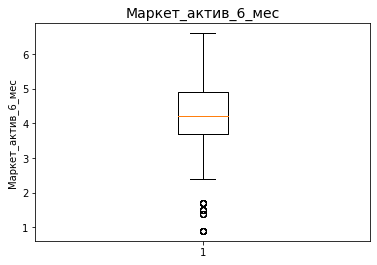

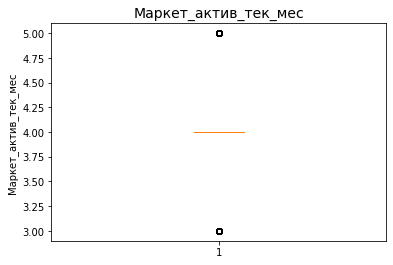

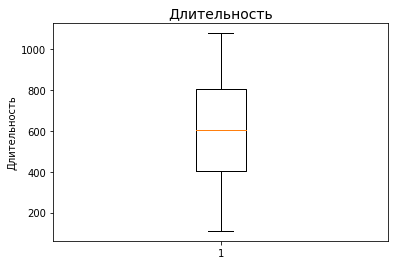

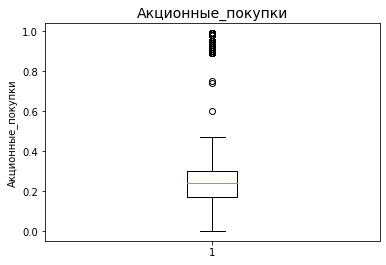

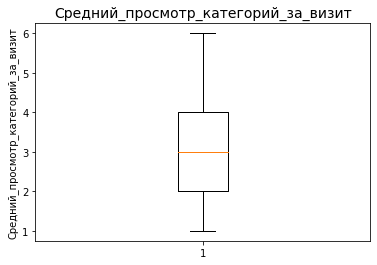

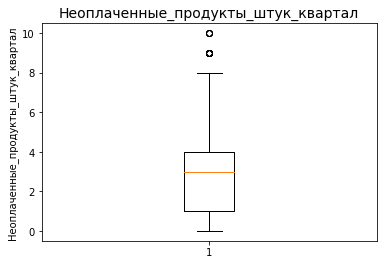

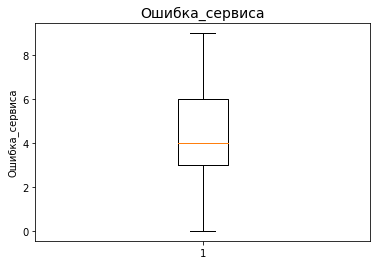

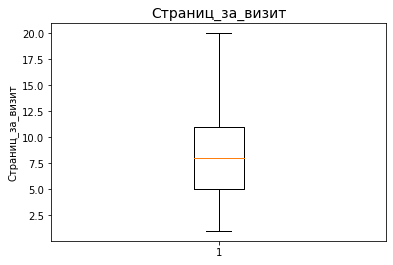

In [28]:
plot_box(market_file)

Количество выбросов небольшое, поэтому не будем их удалять

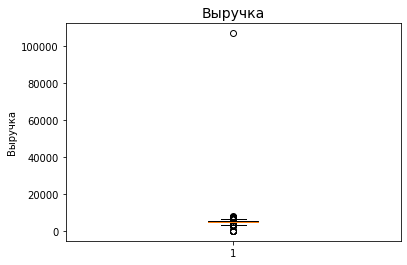

In [29]:
plot_box(market_money)

In [30]:
# Удалим те строки, где выручка равна 0 и выброс
market_money = market_money.query('Выручка != 0')
market_money = market_money[market_money['Выручка'] != max(market_money['Выручка'])]
market_money.shape

(3893, 3)

Было 3900 строк, стало 3893 => удалили 7 строк.

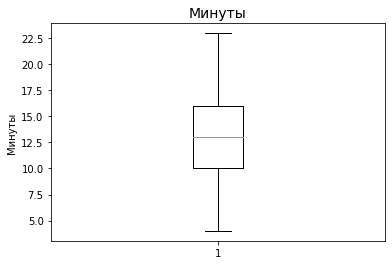

In [31]:
plot_box(market_time)

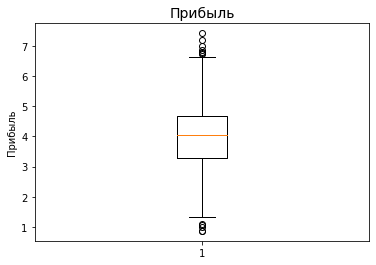

In [32]:
plot_box(money_data)

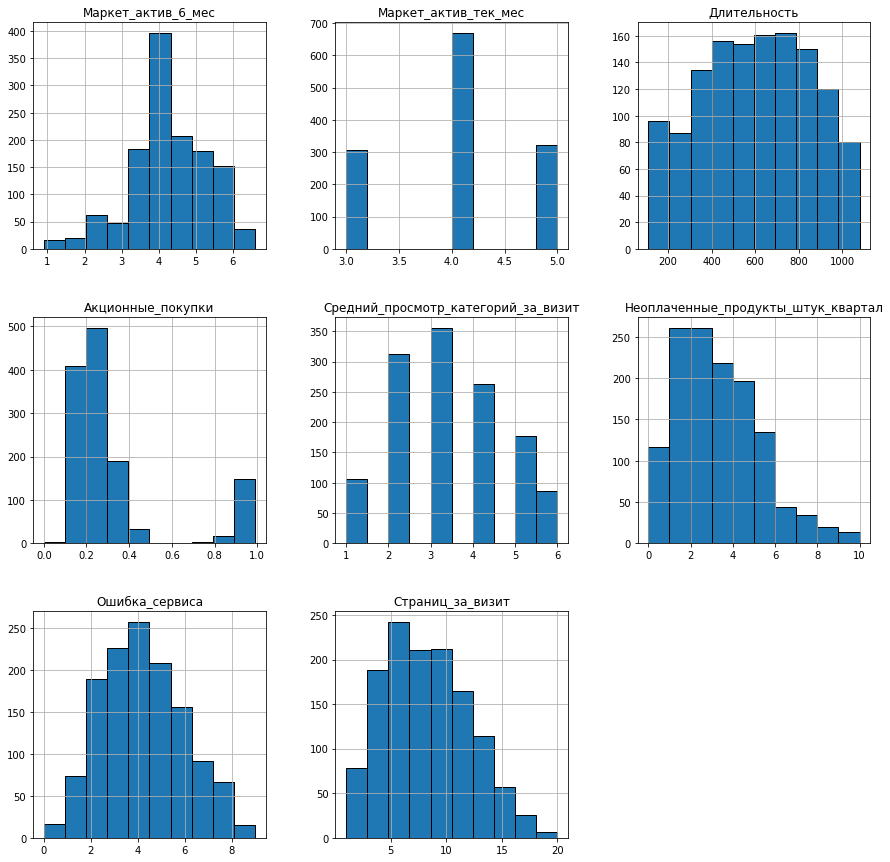

In [33]:
market_file.drop('id', axis=1).hist(figsize=(15, 15), edgecolor='k')
plt.show()

Заметим необычное распредление в столбцах:
* Акционные_покупки  
* Маркет_актив_6_мес  

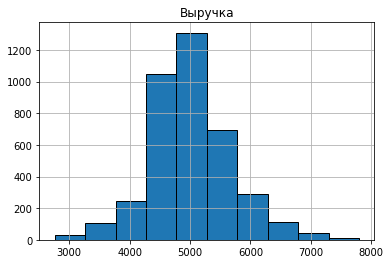

In [34]:
market_money.drop('id', axis=1).hist(edgecolor='k')
plt.show()

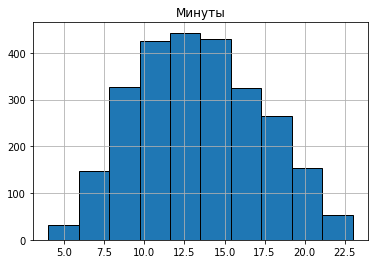

In [35]:
market_time.drop('id', axis=1).hist(edgecolor='k')
plt.show()

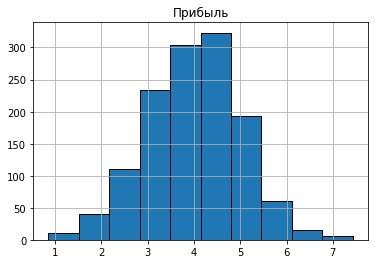

In [36]:
money_data.drop('id', axis=1).hist(edgecolor='k')
plt.show()

Отберите клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период

In [37]:
active_clients = market_file[market_file['Покупательская активность'] == 'Прежний уровень']
active_clients.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
400,215748,Прежний уровень,стандарт,нет,4.3,4,534,0.18,Кухонная посуда,3,1,4,10
401,215749,Прежний уровень,премиум,да,5.8,5,624,0.30,Техника для красоты и здоровья,4,3,6,14
402,215750,Прежний уровень,стандарт,да,4.8,5,634,0.21,Товары для детей,4,5,3,10
403,215751,Прежний уровень,стандарт,да,4.1,4,957,0.17,Техника для красоты и здоровья,5,2,6,9
404,215752,Прежний уровень,стандарт,нет,4.0,4,475,0.30,Мелкая бытовая техника и электроника,3,3,7,7


In [38]:
active_clients.shape

(802, 13)

Получаем 802 клиента с покупательской активностью не менее 3х месяцев

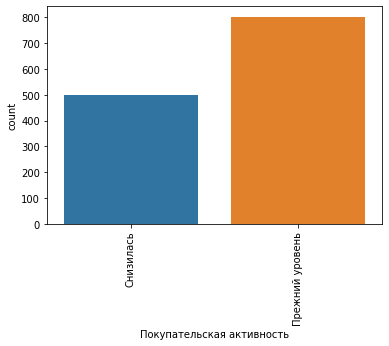

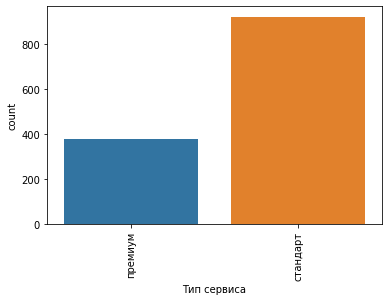

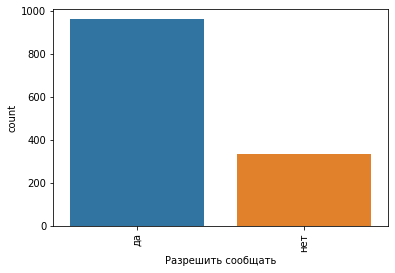

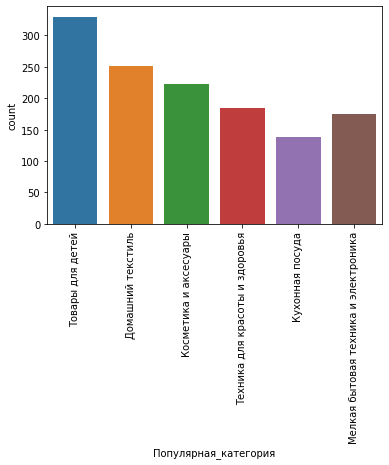

In [39]:
for name in market_file.select_dtypes('object').columns:
    sns.countplot(x=name, data=market_file)
    plt.xticks(rotation=90)
    plt.show()

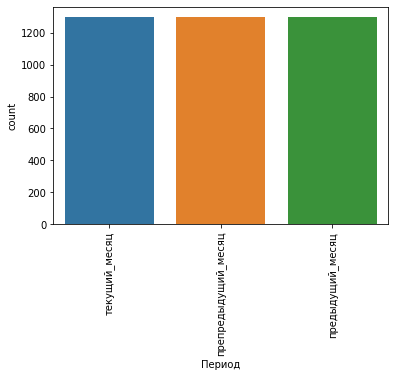

In [40]:
for name in market_money.select_dtypes('object').columns:
    sns.countplot(x=name, data=market_money)
    plt.xticks(rotation=90)
    plt.show()

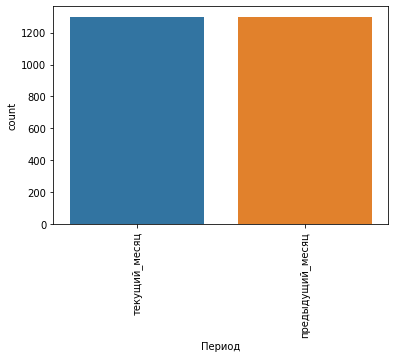

In [41]:
for name in market_time.select_dtypes('object').columns:
    sns.countplot(x=name, data=market_time)
    plt.xticks(rotation=90)
    plt.show()

__Вывод по исследовательскому анализу данных:__

1) Провели статистический анализ признаков;   
2) Построили графики:
* диаграммы размаха (по ним смотрели выбросы)
* гистограммы (по ним смотрели распредление данных)  

3) Отобрали клиентов с покупательской активностью не менее 3х месяцев - 802 клиента.  
4) Удалили строки, где выручка равна 0 - 6 строк.  

## Объединение таблиц

Объедините таблицы __market_file.csv, market_money.csv, market_time.csv.__ Данные о прибыли из файла money.csv при моделировании вам не понадобятся. 

In [42]:
# Переворачивание строк в столбцы для market_money
money_pivot = market_money.pivot_table(index='id', columns='Период')
money_pivot.columns = [col for col in money_pivot.columns]

# Переворачивание строк в столбцы для market_time
time_pivot = market_time.pivot_table(index='id', columns='Период')
time_pivot.columns = [col for col in time_pivot.columns]

# Объединение таблиц по общему идентификатору клиента (id) без дубликатов
merged_data = pd.merge(market_file, money_pivot, on='id', how='left')
merged_data = pd.merge(merged_data, time_pivot, on='id', how='left')

merged_data.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,"(Выручка, предыдущий_месяц)","(Выручка, препредыдущий_месяц)","(Выручка, текущий_месяц)","(Минуты, предыдущий_месяц)","(Минуты, текущий_месяц)"
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,NaN,NaN,3293.1,13,14
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11


In [43]:
merged_data.shape # Все клиенты

(1300, 18)

In [44]:
merged_data.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,"(Выручка, предыдущий_месяц)","(Выручка, препредыдущий_месяц)","(Выручка, текущий_месяц)","(Минуты, предыдущий_месяц)","(Минуты, текущий_месяц)"
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,NaN,NaN,3293.1,13,14
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11


In [45]:
merged_data.isna().sum()

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
(Выручка, предыдущий_месяц)            3
(Выручка, препредыдущий_месяц)         3
(Выручка, текущий_месяц)               1
(Минуты, предыдущий_месяц)             0
(Минуты, текущий_месяц)                0
dtype: int64

In [46]:
merged_data.columns

Index([                                 'id',
                 'Покупательская активность',
                               'Тип сервиса',
                        'Разрешить сообщать',
                        'Маркет_актив_6_мес',
                      'Маркет_актив_тек_мес',
                              'Длительность',
                         'Акционные_покупки',
                      'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
        'Неоплаченные_продукты_штук_квартал',
                            'Ошибка_сервиса',
                          'Страниц_за_визит',
             ('Выручка', 'предыдущий_месяц'),
          ('Выручка', 'препредыдущий_месяц'),
                ('Выручка', 'текущий_месяц'),
              ('Минуты', 'предыдущий_месяц'),
                 ('Минуты', 'текущий_месяц')],
      dtype='object')

In [47]:
merged_data = merged_data.rename(columns = {('Выручка', 'предыдущий_месяц'): 'Выручка_предыдущий_месяц', 
                                            ('Выручка', 'препредыдущий_месяц'): 'Выручка_препредыдущий_месяц',
                                            ('Выручка', 'текущий_месяц'): 'Выручка_текущий_месяц',
                                            ('Минуты', 'предыдущий_месяц'): 'Минуты_предыдущий_месяц',
                                            ('Минуты', 'текущий_месяц'): 'Минуты_текущий_месяц'})

In [48]:
merged_data.columns

Index(['id', 'Покупательская активность', 'Тип сервиса', 'Разрешить сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит', 'Выручка_предыдущий_месяц',
       'Выручка_препредыдущий_месяц', 'Выручка_текущий_месяц',
       'Минуты_предыдущий_месяц', 'Минуты_текущий_месяц'],
      dtype='object')

In [49]:
merged_data = merged_data.dropna()

In [50]:
merged_data.shape

(1296, 18)

In [51]:
merged_data.isna().sum() # пропусков(Nan) нет

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
Выручка_предыдущий_месяц               0
Выручка_препредыдущий_месяц            0
Выручка_текущий_месяц                  0
Минуты_предыдущий_месяц                0
Минуты_текущий_месяц                   0
dtype: int64

## Корреляционный анализ

Проведите корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования. Сделайте выводы о мультиколлинеарности и при необходимости устраните её.

In [52]:
corr_matrix = merged_data.drop('id', axis=1).corr(method='spearman') # Рассчитываем корреляцию

In [53]:
corr_matrix.style.background_gradient(cmap='coolwarm') # Выводим матрицу корреляции

,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Минуты_предыдущий_месяц,Минуты_текущий_месяц
Маркет_актив_6_мес,1.000000,0.061741,-0.044445,-0.276590,0.185013,-0.135045,0.038643,0.319872,-0.003642,0.234728,0.002093,0.273727,0.226968
Маркет_актив_тек_мес,0.061741,1.000000,-0.131967,0.033099,-0.025167,0.061747,0.087343,0.003143,-0.027088,-0.039437,-0.011782,0.013535,-0.063051
Длительность,-0.044445,-0.131967,1.000000,0.029045,-0.043154,-0.108787,0.103562,-0.034495,0.013537,-0.039301,0.015002,-0.123940,0.083048
Акционные_покупки,-0.276590,0.033099,0.029045,1.000000,-0.203401,0.198307,-0.051593,-0.370860,0.005184,-0.269087,0.022255,-0.332548,-0.275313
Средний_просмотр_категорий_за_визит,0.185013,-0.025167,-0.043154,-0.203401,1.000000,-0.251559,0.010034,0.267479,-0.049460,0.149742,-0.070716,0.148279,0.233369
Неоплаченные_продукты_штук_квартал,-0.135045,0.061747,-0.108787,0.198307,-0.251559,1.000000,-0.098582,-0.165412,0.033434,-0.249293,0.061178,-0.183575,-0.214699
Ошибка_сервиса,0.038643,0.087343,0.103562,-0.051593,0.010034,-0.098582,1.000000,0.104482,0.035476,0.090152,0.040477,0.196009,0.078074
Страниц_за_визит,0.319872,0.003143,-0.034495,-0.370860,0.267479,-0.165412,0.104482,1.000000,-0.067610,0.311675,-0.049964,0.450760,0.298120
Выручка_предыдущий_месяц,-0.003642,-0.027088,0.013537,0.005184,-0.049460,0.033434,0.035476,-0.067610,1.000000,0.308041,0.879097,-0.084215,-0.083214
Выручка_препредыдущий_месяц,0.234728,-0.039437,-0.039301,-0.269087,0.149742,-0.249293,0.090152,0.311675,0.308041,1.000000,0.149944,0.348745,0.299783


__Положительная корреляция:__ две переменные увеличиваются вместе и уменьшаются вместе;    
__Отрицательная корреляция:__ одна переменная увеличивается, а другая уменьшается вместе, и наоборот;    
Например, чем больше Средний_просмотр_категорий_за_визит, тем больше Страниц_за_визит, и наоборот(между ними отрицательная корреляция)

In [54]:
def phk_matrix(df):
    # вычисление коэффициентов корреляции phi для датафрейма df
    phik_overview = df.phik_matrix()

    # визуализация тепловой карты коэффициентов корреляции
    plot_correlation_matrix(
        phik_overview.values,
        x_labels=phik_overview.columns,
        y_labels=phik_overview.index,
        title=r"correlation $\phi_K$",
        fontsize_factor=1.5,
        figsize=(15, 12)
    )

interval columns not set, guessing: ['id', 'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'Выручка_предыдущий_месяц', 'Выручка_препредыдущий_месяц', 'Выручка_текущий_месяц', 'Минуты_предыдущий_месяц', 'Минуты_текущий_месяц']


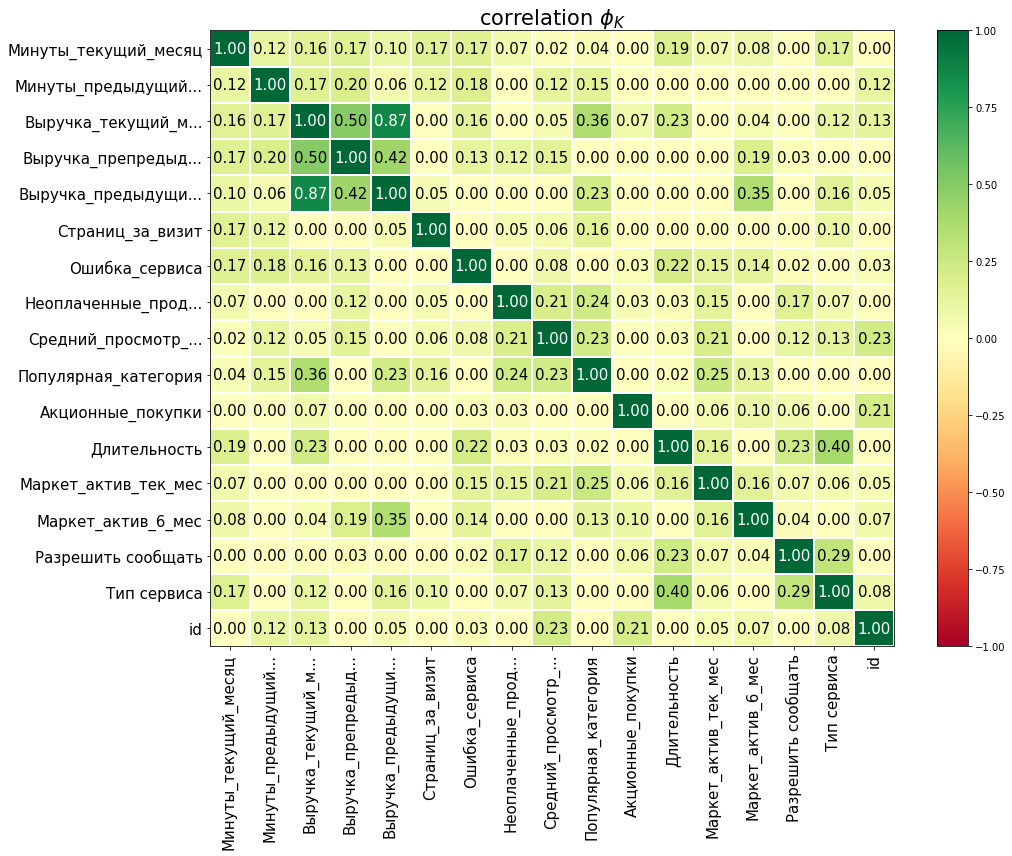

In [55]:
df = merged_data[merged_data['Покупательская активность'] == 'Прежний уровень']
phk_matrix(df)

interval columns not set, guessing: ['id', 'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'Выручка_предыдущий_месяц', 'Выручка_препредыдущий_месяц', 'Выручка_текущий_месяц', 'Минуты_предыдущий_месяц', 'Минуты_текущий_месяц']


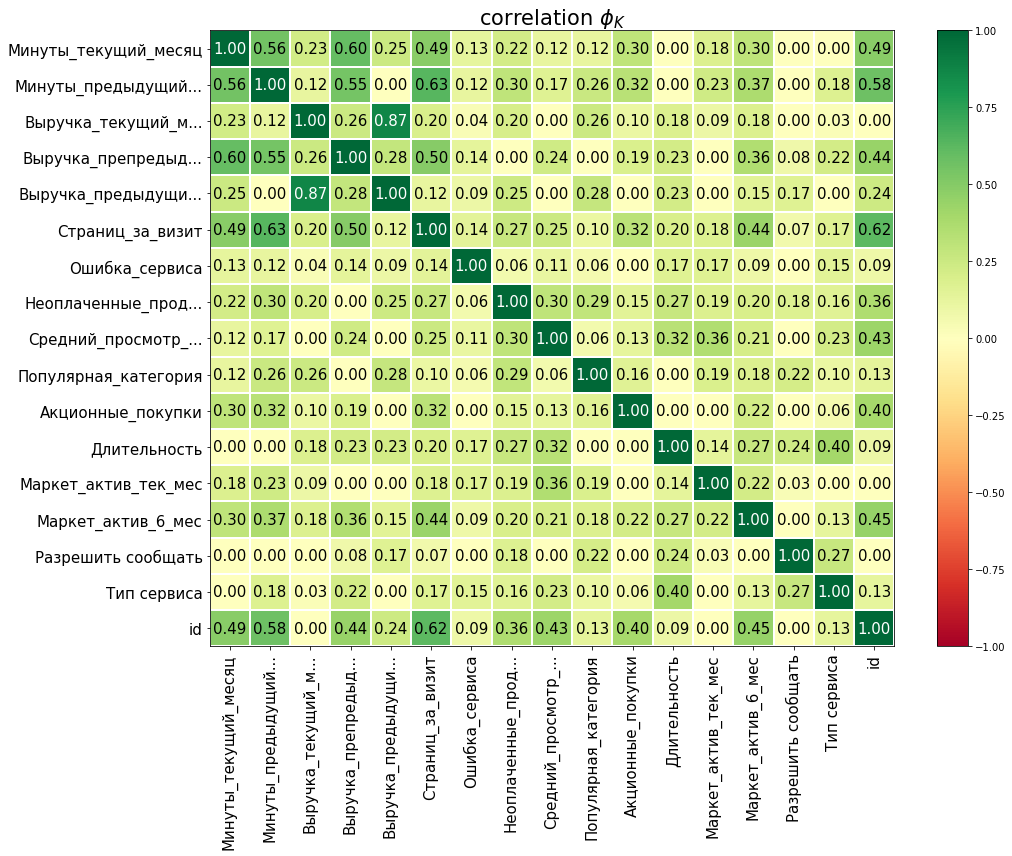

In [56]:
df1 = merged_data[merged_data['Покупательская активность'] == 'Снизилась']
phk_matrix(df1)

In [57]:
merged_data.columns

Index(['id', 'Покупательская активность', 'Тип сервиса', 'Разрешить сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит', 'Выручка_предыдущий_месяц',
       'Выручка_препредыдущий_месяц', 'Выручка_текущий_месяц',
       'Минуты_предыдущий_месяц', 'Минуты_текущий_месяц'],
      dtype='object')

In [58]:
def plt_scatter(data, y, name):
    """Фукнция построения графика рассеяния"""
    sns.scatterplot(x=name, y=y, data=data)
    plt.show()

In [59]:
col_data = merged_data.drop('id', axis=1).select_dtypes(exclude='object').columns

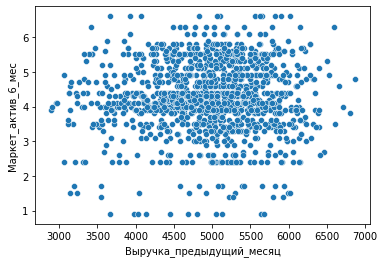

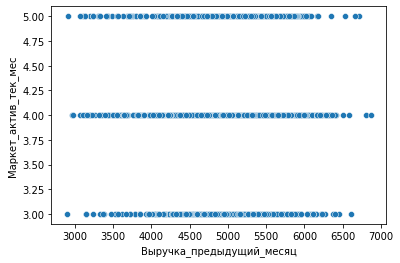

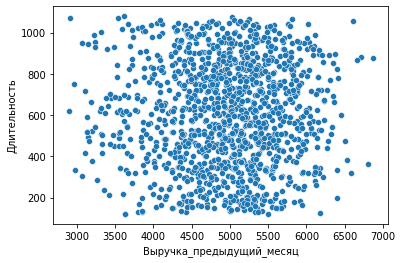

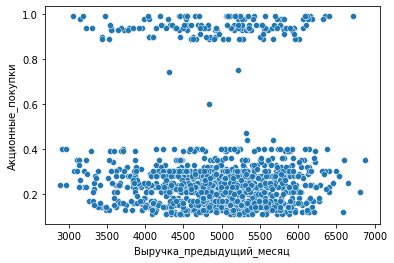

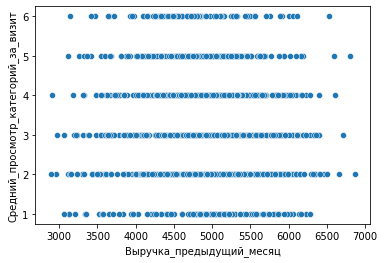

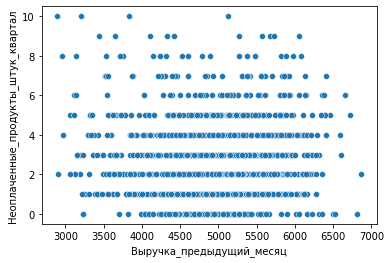

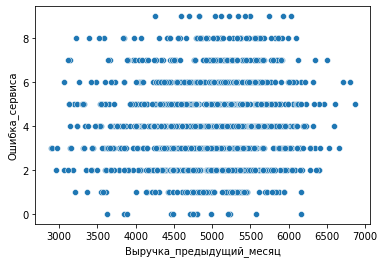

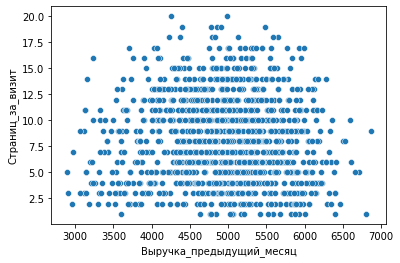

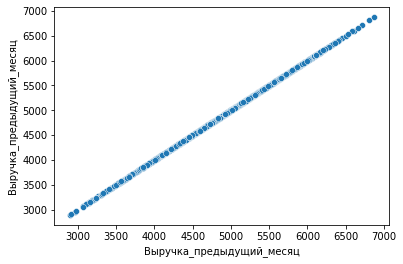

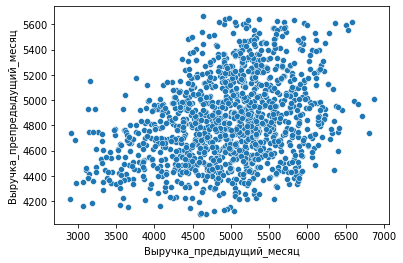

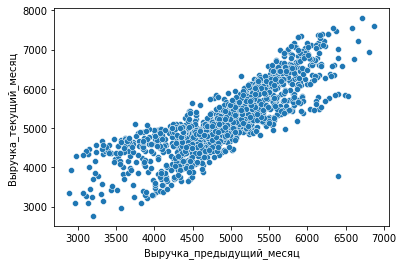

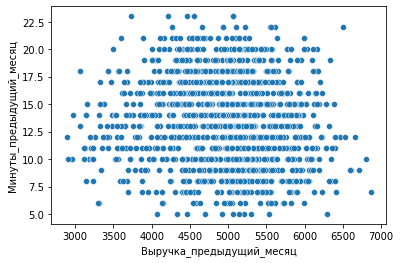

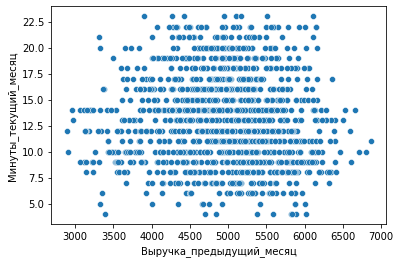

In [60]:
for i in col_data:
    plt_scatter(merged_data, i, 'Выручка_предыдущий_месяц')

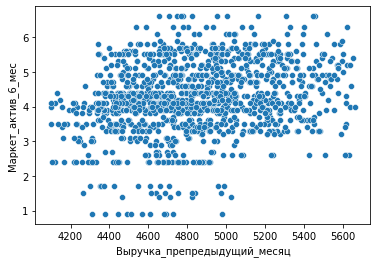

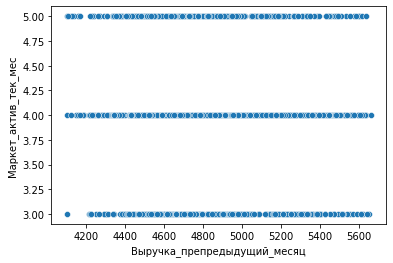

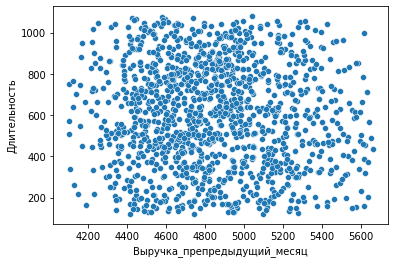

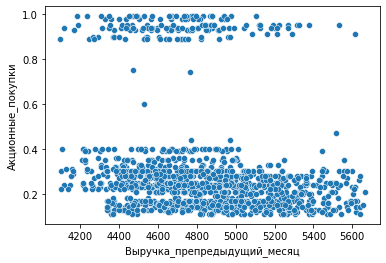

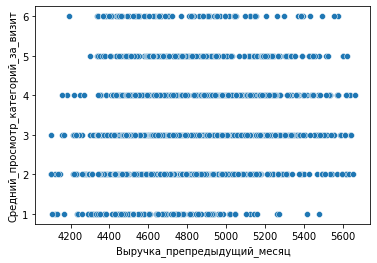

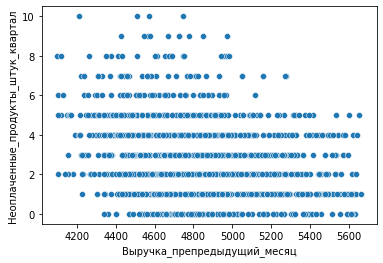

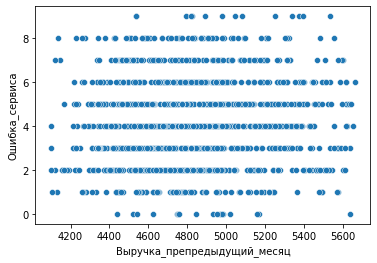

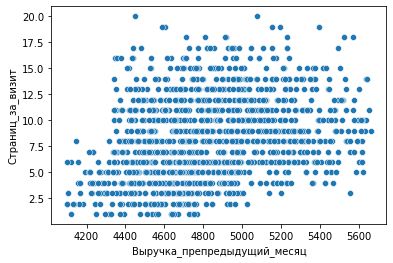

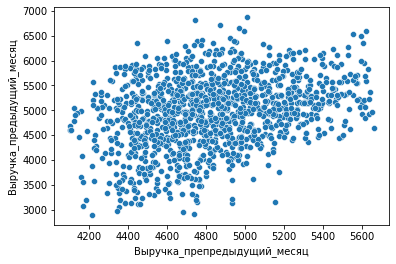

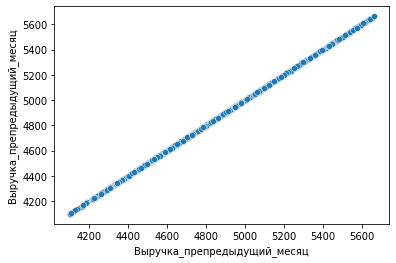

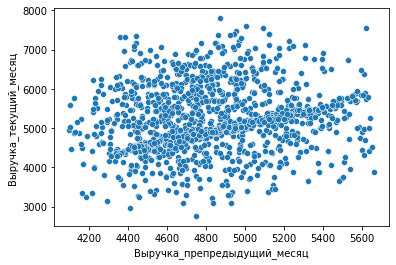

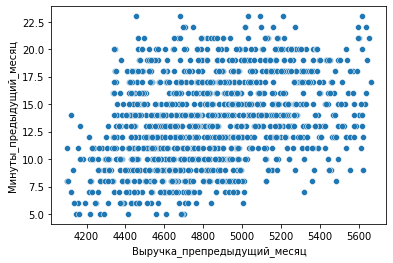

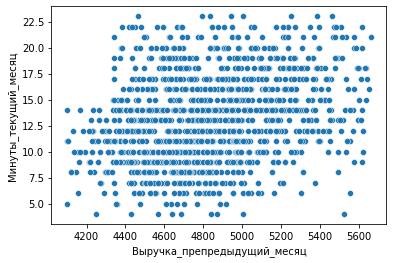

In [61]:
for i in col_data:
    plt_scatter(merged_data, i, 'Выручка_препредыдущий_месяц')

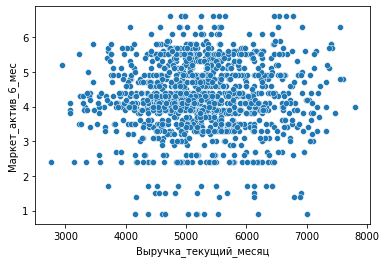

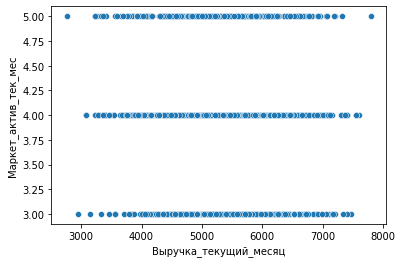

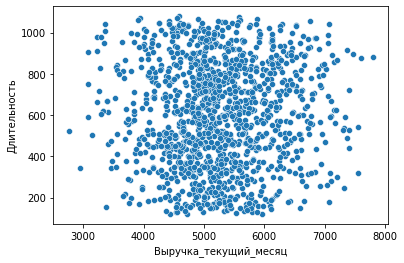

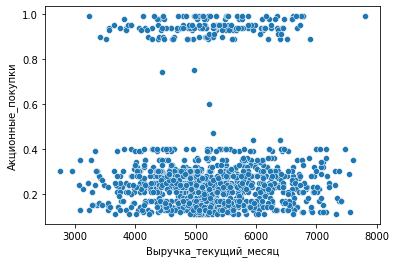

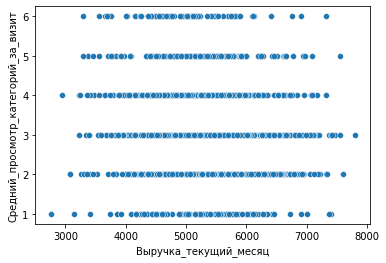

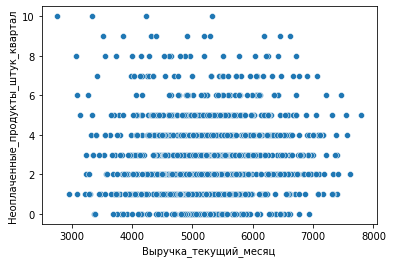

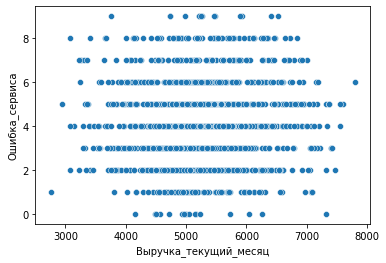

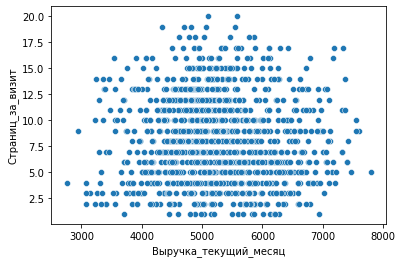

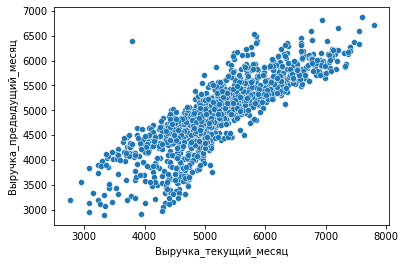

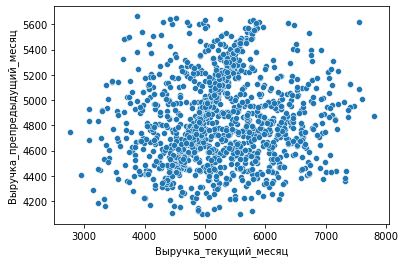

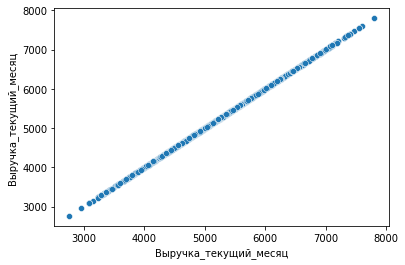

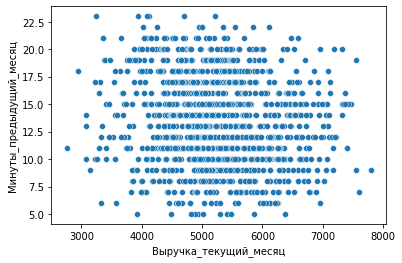

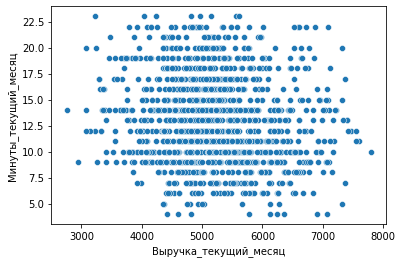

In [62]:
for i in col_data:
    plt_scatter(merged_data, i, 'Выручка_текущий_месяц')

Видим, что выручка за предыдущий месяц связана линейно с выручкой за препредыдущий месяц и с выручкой за текущий месяц 

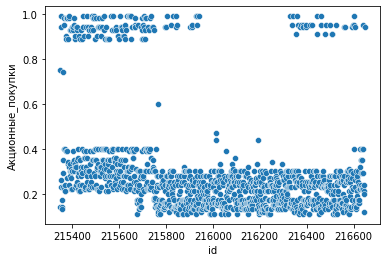

In [63]:
plt_scatter(merged_data, 'Акционные_покупки', 'id')

По графику можно увидеть, что в основном значения находятся в диапазоне примерно до 0.4

In [64]:
columns = ['id', 'Покупательская активность', 'Тип сервиса', 'Разрешить сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит', 'Выручка_предыдущий_месяц',
       'Выручка_препредыдущий_месяц', 'Выручка_текущий_месяц',
       'Минуты_предыдущий_месяц', 'Минуты_текущий_месяц']

# Преобразование названий столбцов в змеиный регистр
columns_snake_case = [col.lower().replace(' ', '_') for col in columns]
merged_data.columns = columns_snake_case

In [65]:
merged_data.columns

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит', 'выручка_предыдущий_месяц',
       'выручка_препредыдущий_месяц', 'выручка_текущий_месяц',
       'минуты_предыдущий_месяц', 'минуты_текущий_месяц'],
      dtype='object')

In [66]:
vif_data = pd.DataFrame() 
vif_data["feature"] = merged_data.drop('id', axis=1).columns
  
vif_data["VIF"] = [variance_inflation_factor(pd.get_dummies(merged_data.drop('id', axis=1)).values, i) 
                          for i in range(len(merged_data.drop('id', axis=1).columns))] 
  
print(vif_data)

                                feature       VIF
0             покупательская_активность  1.259697
1                           тип_сервиса  1.075766
2                    разрешить_сообщать  1.255457
3                    маркет_актив_6_мес  1.251170
4                  маркет_актив_тек_мес  1.300812
5                          длительность  1.296512
6                     акционные_покупки  1.088488
7                  популярная_категория  1.564487
8   средний_просмотр_категорий_за_визит  4.452607
9    неоплаченные_продукты_штук_квартал  1.650347
10                       ошибка_сервиса  3.951888
11                     страниц_за_визит  1.663412
12             выручка_предыдущий_месяц  1.394447
13          выручка_препредыдущий_месяц       inf
14                выручка_текущий_месяц       inf
15              минуты_предыдущий_месяц       inf
16                 минуты_текущий_месяц       inf


VIF выше 5 указывает на высокую мультиколлинеарность, у нас таких значений нет, следовательно, мультиколлинеарности между признаками нет

## Использование пайплайнов

Обучите четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC(). Для каждой из них подберите как минимум один гиперпараметр. Выберите подходящую для задачи метрику, аргументируйте свой выбор. Используйте эту метрику при подборе гиперпараметров.

In [67]:
merged_data.shape

(1296, 18)

In [68]:
merged_data.columns

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит', 'выручка_предыдущий_месяц',
       'выручка_препредыдущий_месяц', 'выручка_текущий_месяц',
       'минуты_предыдущий_месяц', 'минуты_текущий_месяц'],
      dtype='object')

In [69]:
merged_data

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минуты_предыдущий_месяц,минуты_текущий_месяц
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
5,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,3664.0,4704.0,4741.7,14,7
1296,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,4729.0,5299.0,5353.0,12,11
1297,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5160.0,5334.0,5139.2,12,18
1298,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,4923.0,4725.0,5224.6,18,7


In [77]:
RANDOM_STATE = 42
y = merged_data['покупательская_активность']
X = merged_data.drop(['покупательская_активность'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y, 
    train_size=0.75,
    random_state = RANDOM_STATE)

print(X_train.shape, X_test.shape)

# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error'))
    ]
    )

# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + ORD
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ['популярная_категория']),
     ('ord', ord_pipe, ['тип_сервиса', 'разрешить_сообщать']),
     ('num', MinMaxScaler(), ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
                             'акционные_покупки', 'средний_просмотр_категорий_за_визит',
                             'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
                             'страниц_за_визит', 'выручка_предыдущий_месяц',
                             'выручка_препредыдущий_месяц', 'выручка_текущий_месяц',
                             'минуты_предыдущий_месяц', 'минуты_текущий_месяц'])
    ],
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

  
param_grid = [
    # словарь для модели DecisionTreeClassifier()
   # {
     #   'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
     #   'models__max_depth': range(2, 5),
     #   'models__max_features': range(2, 5),
    # #   'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
   # },
   # 
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
        )],
        'models__C': range(1, 14),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

random_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
random_search.fit(X_train, y_train)

print('Лучшая модель и ее параметры:\n\n', random_search.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', random_search.best_score_)

# проверить работу модели на тестовой выборке
# рассчитать прогноз на тестовых данных
y_test_pred = random_search.predict(X_test)

label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test_pred)

print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_encoded)}')

(972, 17) (324, 17)
Лучшая модель и ее параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                

ROC-AUC — это всеохватывающая метрика качества классификации. Она учитывает работу модели при всех возможных значениях порогов и поэтому не зависит от одного конкретного. Это самая общая оценка итогов работы модели.

## Анализ важности признаков

Оцените важность признаков для лучшей модели и постройте график важности с помощью метода SHAP. 

In [81]:
best_model = random_search.best_estimator_

# код ревьюера
best_model['preprocessor'].fit_transform(X_train)
best_model['preprocessor'].transform(X_train)
best_model['preprocessor'].get_feature_names_out()
data = pd.DataFrame(best_model['preprocessor'].transform(X_train),\
                      columns=best_model['preprocessor'].get_feature_names_out())


explainer = shap.LinearExplainer(best_model['models'], data)

shap_values = explainer.shap_values(data)
shap_obj = explainer(data)

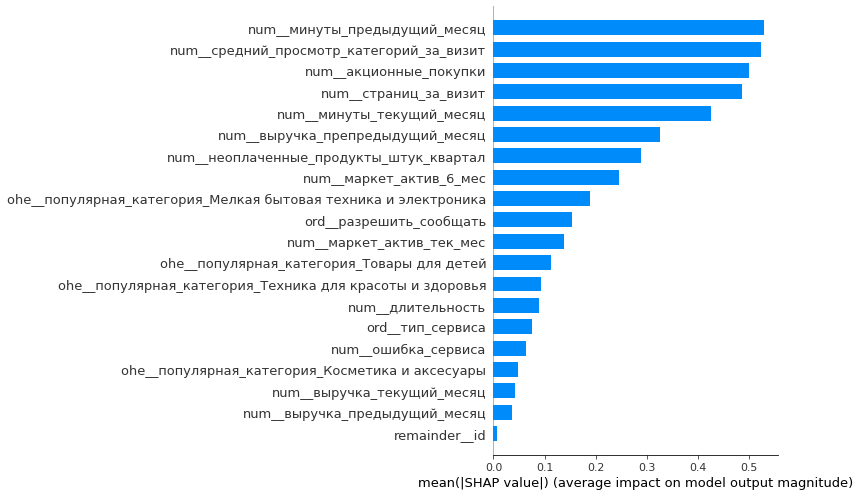

In [85]:
shap.summary_plot(shap_obj, data, plot_type='bar', plot_size=(11,7))

Самый большой вес у признака __минуты_предыдущий_месяц__, он сильнее всего влияет на прогнозы модели.

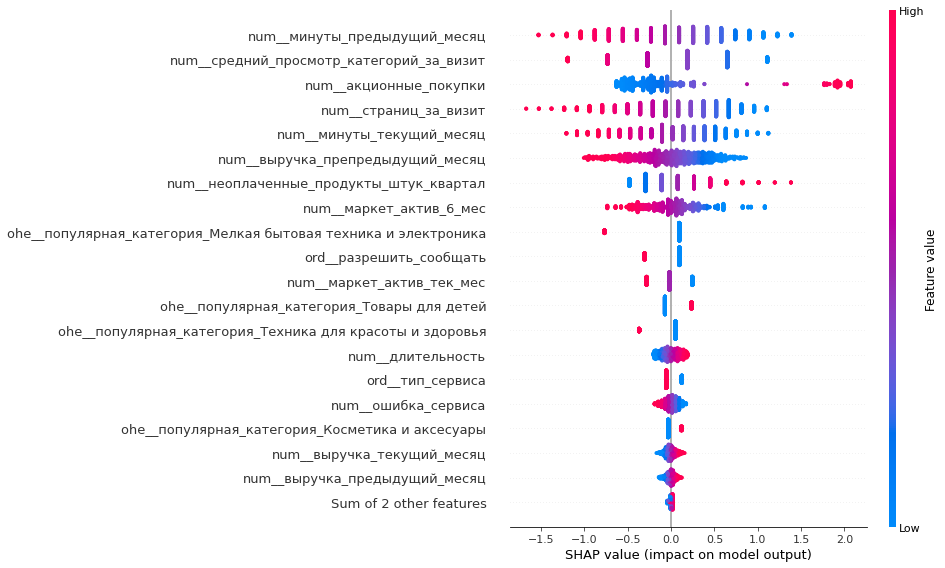

In [84]:
shap.plots.beeswarm(shap_obj, max_display=20)

* Негативные значения Шепли слева от центральной вертикальной линии означают, что признак склоняет модель отнести объекты к классу 0, а положительные справа — к классу 1.  
* Чем толще линия по вертикали, тем больше наблюдений сгруппированы вместе: у них близкие значения Шепли. Это значит, что модель уверенно присваивает SHAP-значения, с учётом закономерностей в данных.
* Цвет точки отражает значения каждого признака объекта: чем краснее объект, тем больше признак, указанный на оси 𝑌


In [ ]:
shap_values.values

In [ ]:
shap.summary_plot(shap_values.values, X_test.columns, plot_type="bar")
plt.show()

Видим, что признак __Маркет_актив_6_мес__ сильнее всего влияет на целевой признак

## Сегментация покупателей

Видим, что 802 клиента, у которых покупательская активность не снижалась в течении 3 месяцев

Самая __поплуряная категория__ - Товары для детей   
Самая __НЕ популярная категория__ - Кухонная посуда. Скорее всего потому что, не так часто покупается, чем товары для детей.   
По столбцу Акционные покупки, видим, что доля в категории Товары для детей выше, чем в категории Кухонная посуда : 0.18 и 0.21 соответсвенно.
Чтобы увеличить покупательскую активность у категории Кухонная посуда, можно сделать больше акционных товаров, предложить клиентам бонусы за покупку, например, от двух товаров.

In [106]:
market_money

,id,Период,Выручка
1,215348,текущий_месяц,3293.1
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
...,...,...,...
3895,216646,препредыдущий_месяц,4725.0
3896,216646,предыдущий_месяц,4923.0
3897,216647,предыдущий_месяц,4720.0
3898,216647,препредыдущий_месяц,5183.0


## Общий вывод

__1.Загрузка данных__:  
1) Загрузили данные;   
2) Посмотрели описание данных и размерности датасетов.  

__2.Предобработка данных__:   
1) Изучили общую информацию о каждом датасете;  
2) Проверили наличие дубликатов и пропусков;   
3) Поработали с неявными дубликатами, например, заменили стандартт на стандарт.  

__3.Исследовательский анализ данных__:  
1) Провели статистический анализ признаков;  
2) Построили графики;   
3) Отобрали клиентов с покупательской активностью не менее 3х месяцев - 802 клиента;  
4) Удалили строки, где выручка равна 0 - 6 строк.  

__4.Объединение таблиц__: 

Объединили три таблицы.

__5.Корреляционный анализ данных__:     
1) Сделали вывод :         
_Положительная корреляция:_ две переменные увеличиваются вместе и уменьшаются вместе;     
_Отрицательная корреляция:_ одна переменная увеличивается, а другая уменьшается вместе, и наоборот;   
Например, чем больше Средний_просмотр_категорий_за_визит, тем больше Страниц_за_визит, и наоборот(между ними отрицательная корреляция);  
2) Построили графики.  

__6.Использование пайплайнов__:  
1) Построили пайплайн, который выявил лучшую модель: KNeighborsClassifier(n_neighbors=2);   
2) ROC-AUC — это всеохватывающая метрика качества классификации. Она учитывает работу модели при всех возможных значениях   порогов и поэтому не зависит от одного конкретного. Это самая общая оценка итогов работы модели.   

__7.Анализ важностии признаков__:       
1) Построили график с SHAP значениями;   
2) По графику выявили, что признак Маркет_актив6мес сильнее всего влияет на целевой признак.  

__8.Сегментация покупателей__:

Самая поплуряная категория - Товары для детей.       
Самая НЕ популярная категория - Кухонная посуда. Скорее всего потому что, не так часто покупается, чем товары для детей.
По столбцу Акционные покупки, видим, что доля в категории Товары для детей выше, чем в категории Кухонная посуда : 0.18 и 0.21 соответсвенно. Чтобы увеличить покупательскую активность у категории Кухонная посуда, можно сделать больше акционных товаров, предложить клиентам бонусы за покупку, например, от двух товаров.

